# Homework 2. Latent Variable Models

- VAEs on 2D Data (5 points)
- VAEs on images (5 points)
- **VQ-VAE on images (20 points)**
- \*Bonus

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## VQ-VAE (20 points) 

You will train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on CIFAR-10 and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
    * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks, and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful. But do not forget about autoregressive property in PixelCNN, use normalization carefully!
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

In [6]:
from collections import OrderedDict, defaultdict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

Files already downloaded and verified


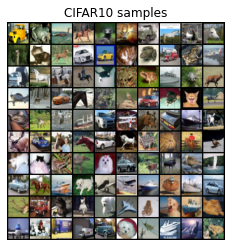

Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat
(26032, 32, 32, 3)


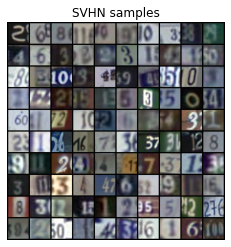

In [7]:
from torchvision.datasets import SVHN, CIFAR10
from torchvision.utils import make_grid
import numpy as np

def show_samples(samples, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


DATA_DIR = './data'
def get_cifar10():
    train = CIFAR10(root=f'{DATA_DIR}/cifar10', train=True, download=True).data
    test = CIFAR10(root=f'{DATA_DIR}/cifar10', train=False).data
    return train, test


def get_svhn():
    train = SVHN(root=f'{DATA_DIR}/svhn', split='train', download=True).data.transpose(0, 2, 3, 1)
    test = SVHN(root=f'{DATA_DIR}/svhn', split='test', download=True).data.transpose(0, 2, 3, 1)
    return train, test


def visualize_cifar10():
    _, test = get_cifar10()
    samples = test[np.random.choice(len(test), 100)]
    show_samples(samples, title="CIFAR10 samples")


def visualize_svhn():
    _, test = get_svhn()
    print(test.shape)
    samples = test[np.random.choice(len(test), 100)]
    show_samples(samples, title="SVHN samples")

visualize_cifar10()
visualize_svhn()

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [8]:
def train_epoch(model, train_loader, optimizer, epoch, grad_clip=None, additional_model=None):
    """
    train model on loader for single epoch
    returns Dict[str, List[float]] - dict of losses on each training batch
    """
    model.train()

    losses = defaultdict(list)
    
    for x in train_loader:
        x = x.to(model.device)
        if additional_model is not None:
            x, _ = additional_model.encode(x)
            x.detach()
        l = model.loss(x)
        optimizer.zero_grad()
        l['loss'].backward()
        optimizer.step()

        for loss_name, loss_value in l.items():
            losses[loss_name].append(loss_value.item())

    return losses


def valid_epoch(model, data_loader, additional_model=None):
    """
    evaluates model on dataset
    returns Dict[str, float] - dict with average losses on entire dataset
    """
    model.eval()
    average_losses = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            x = x.to(model.device)
            if additional_model is not None:
                x, _ = additional_model.encode(x)
                x.detach()
            l = model.loss(x)

            for loss_name, loss_value in l.items():
                average_losses[loss_name] += loss_value.item() * x.shape[0]

    for k in average_losses:
        average_losses[k] /= len(data_loader.dataset)
    return average_losses


def train_loop(model, train_loader, test_loader, epochs=10, lr=1e-3, grad_clip=None, additional_model=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = defaultdict(list), defaultdict(list)
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, epoch, grad_clip, additional_model)
        test_loss = valid_epoch(model, test_loader, additional_model)

        print(f'Epoch {epoch}: test_loss={test_loss}')

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return model, train_losses, test_losses

In [9]:
def normalize(x):
    """
    [0, 255] -> [-1, 1]
    """
    return (x.astype(np.float32) - 127.5) / 127.5


def restore(x):
    """
    [-1, 1] -> [0, 255]
    """
    return (x * 127.5 + 127.5).astype(np.uint8)

class VQVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=256, K=128, device='cuda'):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.K = K

        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, latent_dim, 4, 2, 1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
            nn.Conv2d(latent_dim, latent_dim, 4, 2, 1),
            ResidualBlock(latent_dim),
            ResidualBlock(latent_dim),
        )

        self.decoder = nn.Sequential(
            ResidualBlock(latent_dim),
            ResidualBlock(latent_dim),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(latent_dim, latent_dim, 4, 2, 1),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(),
            nn.ConvTranspose2d(latent_dim, input_dim, 4, 2, 1),
            nn.Tanh(),
        )

        self.vq_embedding = VQEmbedding(K, latent_dim)

        self.device = device
        self.to(device)


    def encode(self, x):
        z_e_x = self.encoder(x)
        latents = self.vq_embedding(z_e_x)
        return latents, z_e_x

    def decode(self, latents):
        z_q_x = self.vq_embedding.embedding(latents).permute(0, 3, 1, 2)  # (B, D, H, W)
        x_tilde = self.decoder(z_q_x)
        return x_tilde, z_q_x

    def forward(self, x):
        latents, z_e_x = self.encode(x)
        x_tilde, z_q_x = self.decode(latents)
        #(z_q(x) - z_e(x)).detach() + z_e(x)
        return x_tilde, z_e_x, z_q_x

    def loss(self, x):
        x_tilde, z_e_x, z_q_x = self(x)

        # Reconstruction loss
        loss_recons = F.mse_loss(x_tilde, x)
        # Vector quantization objective
        loss_vq = F.mse_loss(z_q_x, z_e_x.detach())
        # Commitment objective
        loss_commit = F.mse_loss(z_e_x, z_q_x.detach())

        return {'loss': loss_recons + loss_vq + loss_commit, 'recon_loss': loss_recons, 'vq_loss': loss_vq, 'commit_loss': loss_commit}


class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1),
            nn.BatchNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)


class VQEmbedding(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.embedding = nn.Embedding(K, D)
        self.embedding.weight.data.uniform_(-1./K, 1./K)

    def forward(self, z_e_x):
        # z_e_x - (B, D, H, W)
        # emb   - (K, D)

        emb = self.embedding.weight
        dists = torch.pow(
            z_e_x.unsqueeze(1) - emb[None, :, :, None, None],
            2
        ).sum(2)

        latents = dists.min(1)[1]
        return latents

In [10]:
class PixelCNN(nn.Module):
    def __init__(self, input_dim, n_filters=64,
               kernel_size=7, n_layers=15, device='cuda'):
        super().__init__()
        assert n_layers >= 2
        
        self.embedding = nn.Embedding(input_dim, n_filters)

        modules = []
        modules += [
            MaskedConv2D('A', in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),

        ]

        for _ in range(n_layers):
            modules += [
                MaskedConv2D('B', in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size, padding=kernel_size // 2),
                #nn.BatchNorm2d(n_filters),
                nn.ReLU()
            ]
        

        modules += [
            MaskedConv2D('B', in_channels=n_filters, out_channels=512, kernel_size=1, padding=0),
            #nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            MaskedConv2D('B', in_channels=512, out_channels=input_dim, kernel_size=1, padding=0),
        ]

        self.net = nn.ModuleList(modules)

        self.device = device
        self.to(device)
        
    def forward(self, x, cond=None):
        x = self.embedding(x).permute(0, 3, 1, 2)
        for layer in self.net:
            x = layer(x)

        #return x.permute(0, 4, 1, 2, 3)
        return x

    def loss(self, x):
        target = x
        pred = self.forward(x)
        
        return {'loss': F.cross_entropy(pred, target)}

    def sample(self, n):
        samples = torch.zeros(n, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.n_channels):
                        logits = self.forward(samples)[:, :, k, r, c]
                        probs = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()
    

class MaskedConv2D(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)
    
    def forward(self, x):
        """
        x: (N, C_in, H_in, W_in) torch.Tensor
        Returns
          - out (N, C_out, H_out, W_out) should be conv2d(x, weight * mask) + bias 
        """
        return self._conv_forward(x, self.weight * self.mask, self.bias)
    
    def create_mask(self, mask_type):
        assert mask_type == 'A' or mask_type == 'B'
        k = self.kernel_size[0]
        for i in range(k // 2):
            self.mask[:, :, i] = torch.ones(1, k)
        for i in range(k // 2):
            self.mask[:, :, k // 2, i] = 1
        self.mask[:, :, k // 2, k // 2] = 1 if mask_type == 'B' else 0
        

In [11]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given ('cifar' or 'svhn'). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """
    device = 'cuda'

    K = 128

    vqvae = VQVAE(input_dim=3, K=K, device=device)
    train_loader = data.DataLoader(torch.from_numpy(normalize(train_data)).permute(0, 3, 1, 2), batch_size=128, shuffle=True) # permute
    test_loader = data.DataLoader(torch.from_numpy(normalize(test_data)).permute(0, 3, 1, 2), batch_size=128) # permute
    vqvae_trained, train_losses_vqvae, test_losses_vqvae = train_loop(vqvae, train_loader, test_loader,
                                           epochs=1, lr=1e-3)
    
    pixelcnn = PixelCNN(input_dim=K, device=device)
    pixelcnn_trained, train_losses_pixelcnn, test_losses_pixelcnn = train_loop(pixelcnn, train_loader, test_loader,
                                        epochs=1, lr=1e-3, additional_model=vqvae_trained)
    #train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['vq_loss'], train_losses['commit_loss']), axis=1)
    #test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['vq_loss'], test_losses['commit_loss']), axis=1)

    #samples = model.sample(100)
    #reconstructions = get_reconstructions(model, test_data[:50])
    #interpolations = get_interpolations(model, test_data[50:70])
    #print(samples.shape, reconstructions.shape, interpolations.shape)

    #return train_losses, test_losses, None, None, None, None
    return train_losses_vqvae['loss'], test_losses_vqvae['loss'], train_losses_pixelcnn['loss'], test_losses_pixelcnn['loss'], None, None

### Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

In [12]:
def show_training_plot(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.show()


def q3_results(dset_id, fn):
    if dset_id.lower() == 'cifar':
        train_data, test_data = get_cifar10()
    elif dset_id.lower() == 'svhn':
        train_data, test_data = get_svhn()
    else:
        raise ValueError("Unsupported dataset")

    vqvae_train_losses, vqvae_test_losses, pixelcnn_train_losses, pixelcnn_test_losses, \
        samples, reconstructions = fn(train_data, test_data, dset_id)
    #samples, reconstructions = samples.astype('float32'), reconstructions.astype('float32')
    print(f'VQ-VAE Final Test Loss: {vqvae_test_losses[-1]:.4f}')
    print(f'PixelCNN Prior Final Test Loss: {pixelcnn_test_losses[-1]:.4f}')
    show_training_plot(vqvae_train_losses, vqvae_test_losses, 
                           f'(VQ-VAE) Dataset {dset_id} Train Plot')
    show_training_plot(pixelcnn_train_losses, pixelcnn_test_losses, 
                           f'(PixelCNN) Dataset {dset_id} Train Plot')
    #show_samples(samples, title=f'{dset_id} samples')
    #show_samples(reconstructions, title=f'{dset_id} Reconstructions')


q3_results('cifar', q3)
#q3_results('svhn', q3)

Files already downloaded and verified
Epoch 0: test_loss=defaultdict(<class 'float'>, {'loss': 0.2876652941703796, 'recon_loss': 0.2813937428474426, 'vq_loss': 0.003135775795578957, 'commit_loss': 0.003135775736346841})


RuntimeError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 3.95 GiB total capacity; 1.37 GiB already allocated; 1001.69 MiB free; 2.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [56]:
train_data, test_data = get_cifar10()
vqvae = VQVAE(input_dim=3)
train_loader = data.DataLoader(torch.from_numpy(normalize(train_data)).permute(0, 3, 1, 2), batch_size=128, shuffle=True) # permute
test_loader = data.DataLoader(torch.from_numpy(normalize(test_data)).permute(0, 3, 1, 2), batch_size=128) # permute
vqvae_trained, train_losses, test_losses = train_loop(vqvae, train_loader, test_loader,
                                        epochs=1, lr=1e-3)

Files already downloaded and verified
Epoch 0: test_loss=defaultdict(<class 'float'>, {'loss': 0.3225492262840271, 'recon_loss': 0.054338265961408616, 'vq_loss': 0.13410548014640808, 'commit_loss': 0.13410548014640808})


In [61]:
pixelcnn = PixelCNN(input_dim=128)

pixelcnn_trained, train_losses, test_losses = train_loop(pixelcnn, train_loader, test_loader,
                                        epochs=1, lr=1e-3, additional_model=vqvae_trained)

Epoch 0: test_loss=defaultdict(<class 'float'>, {'loss': 2.2203493434906005})


# Bonus


Some additional tasks will wait you in `bonus.ipynb` section